## Check heatmap of generator

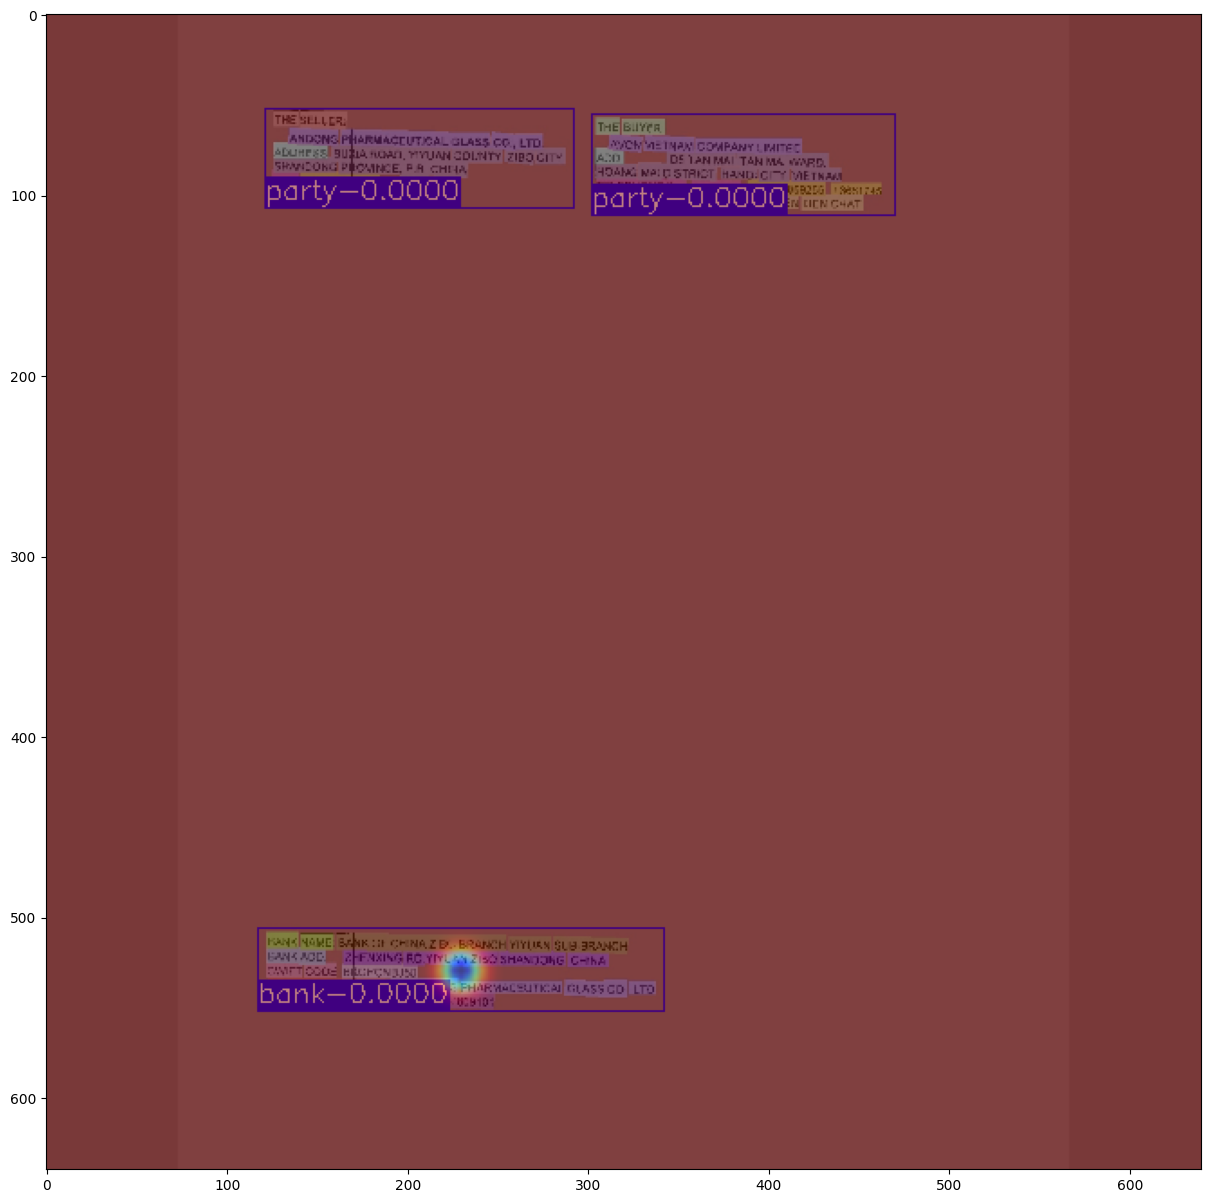

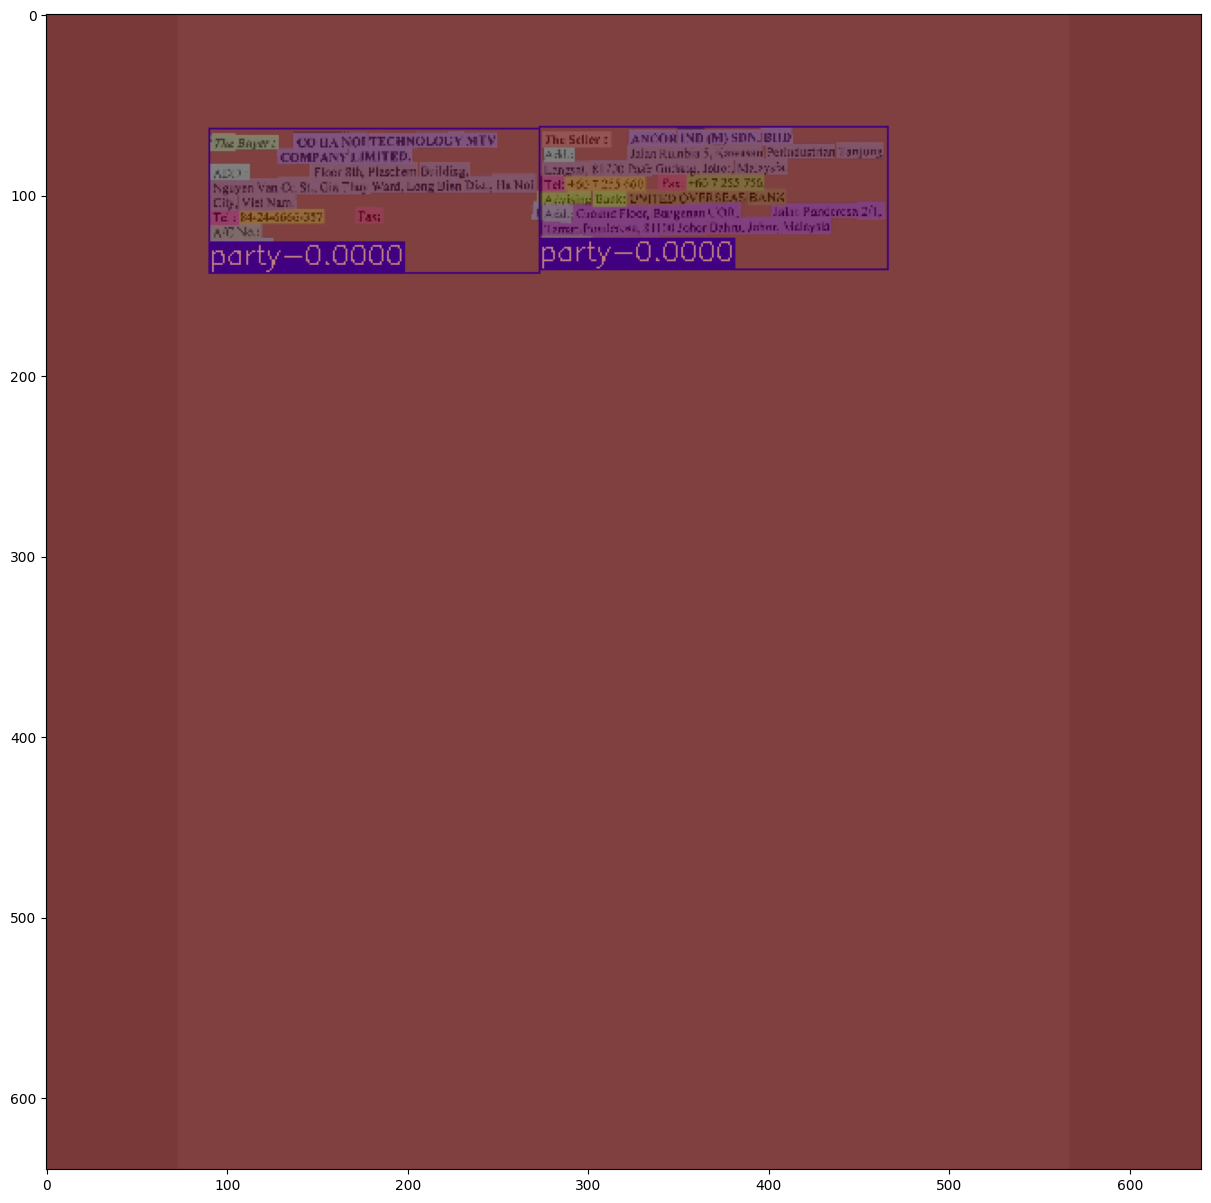

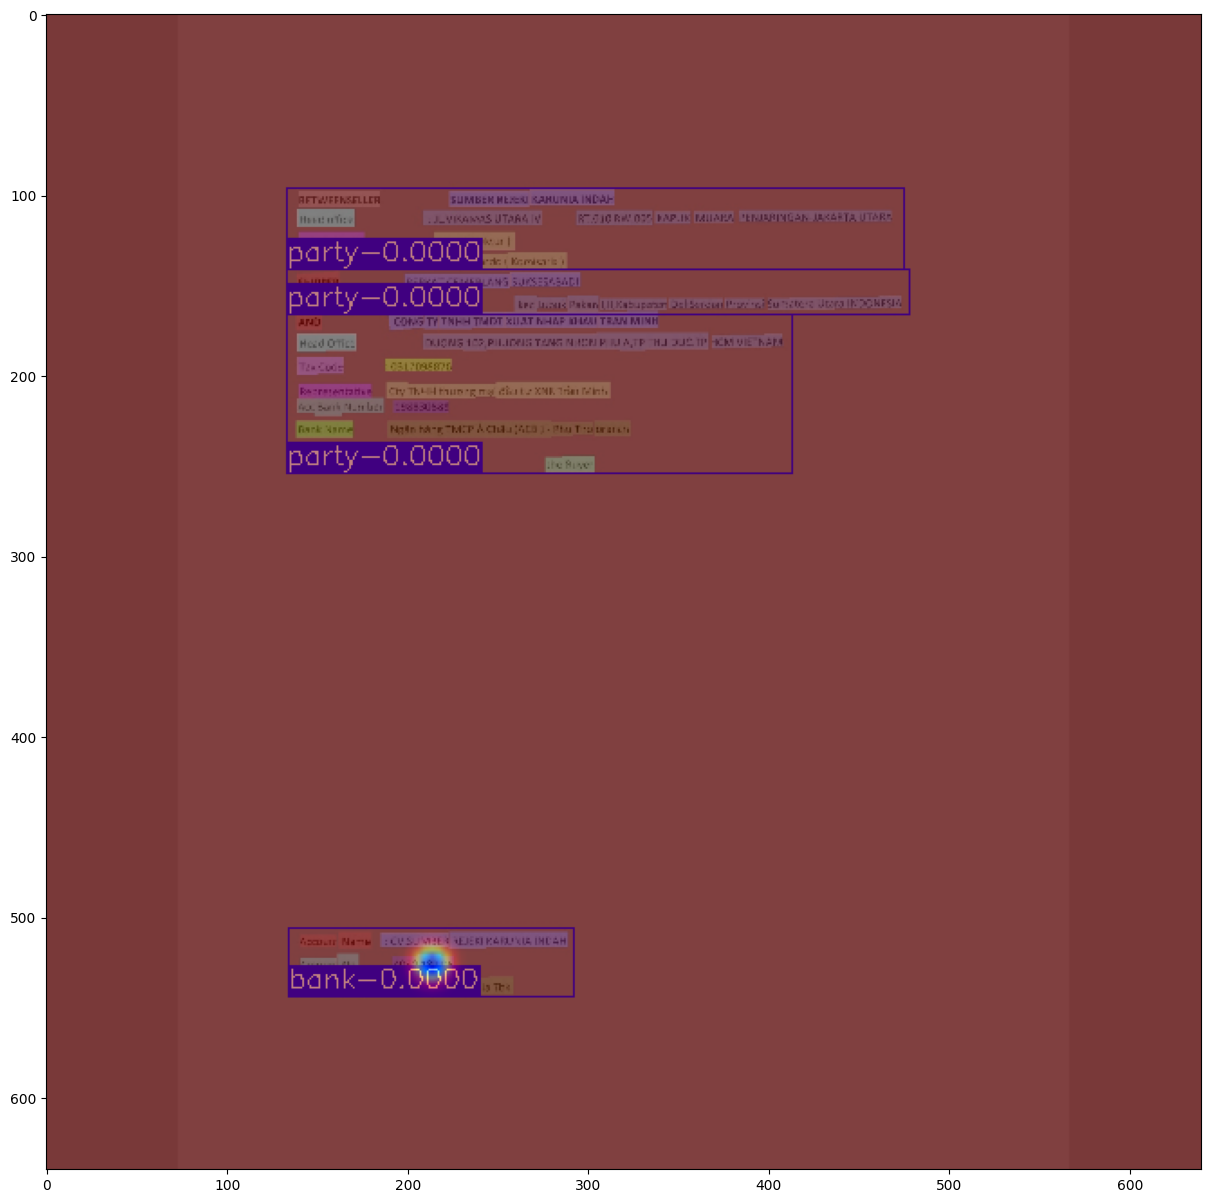

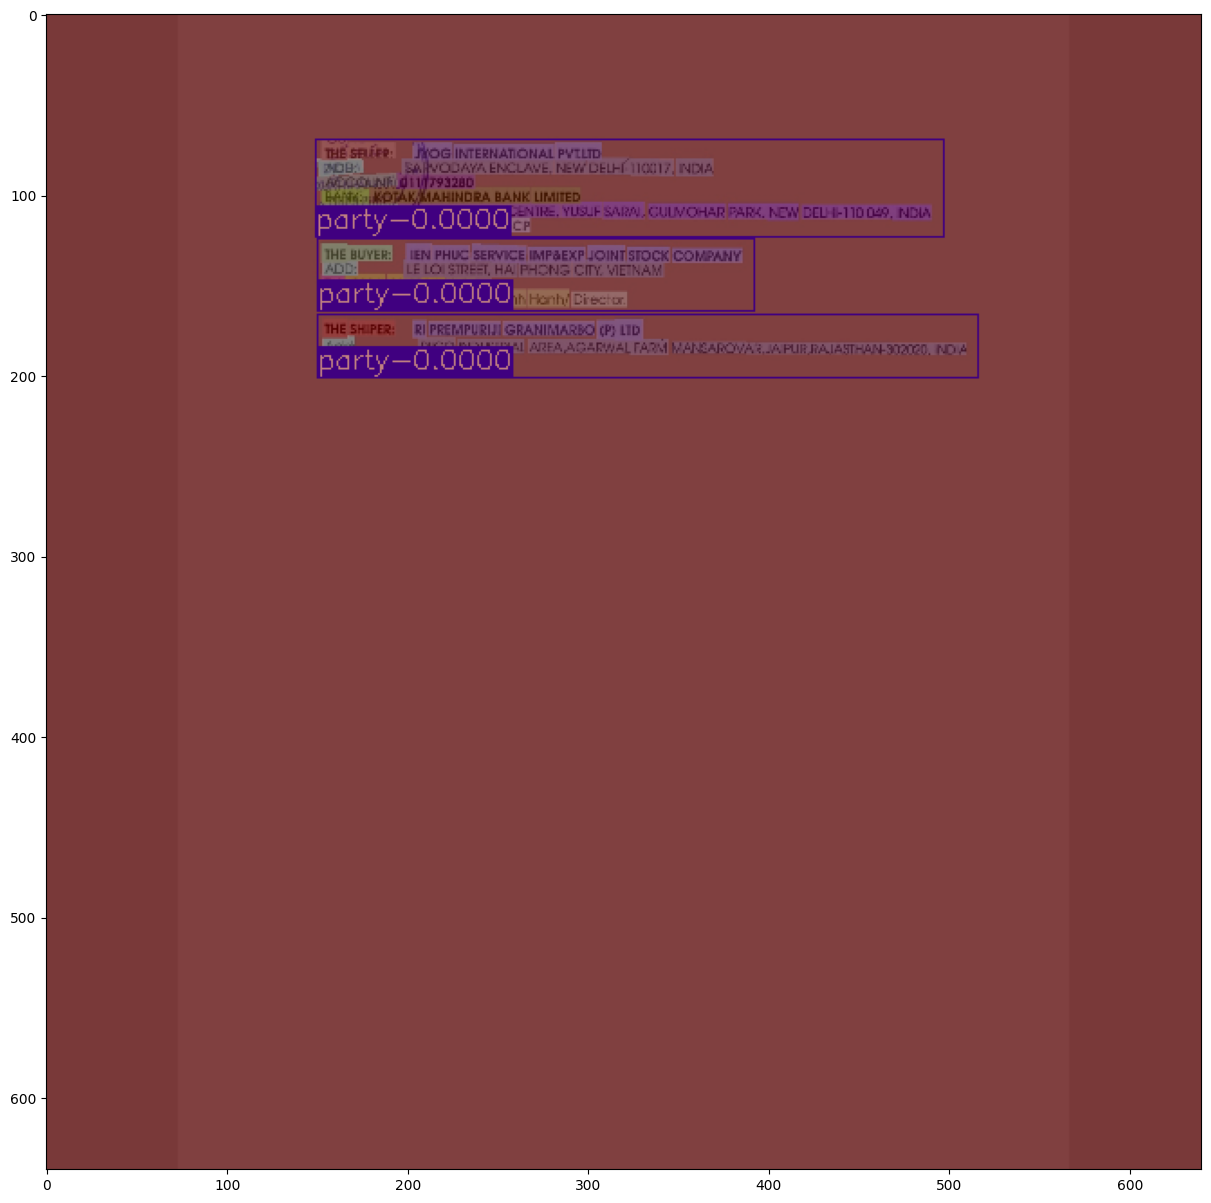

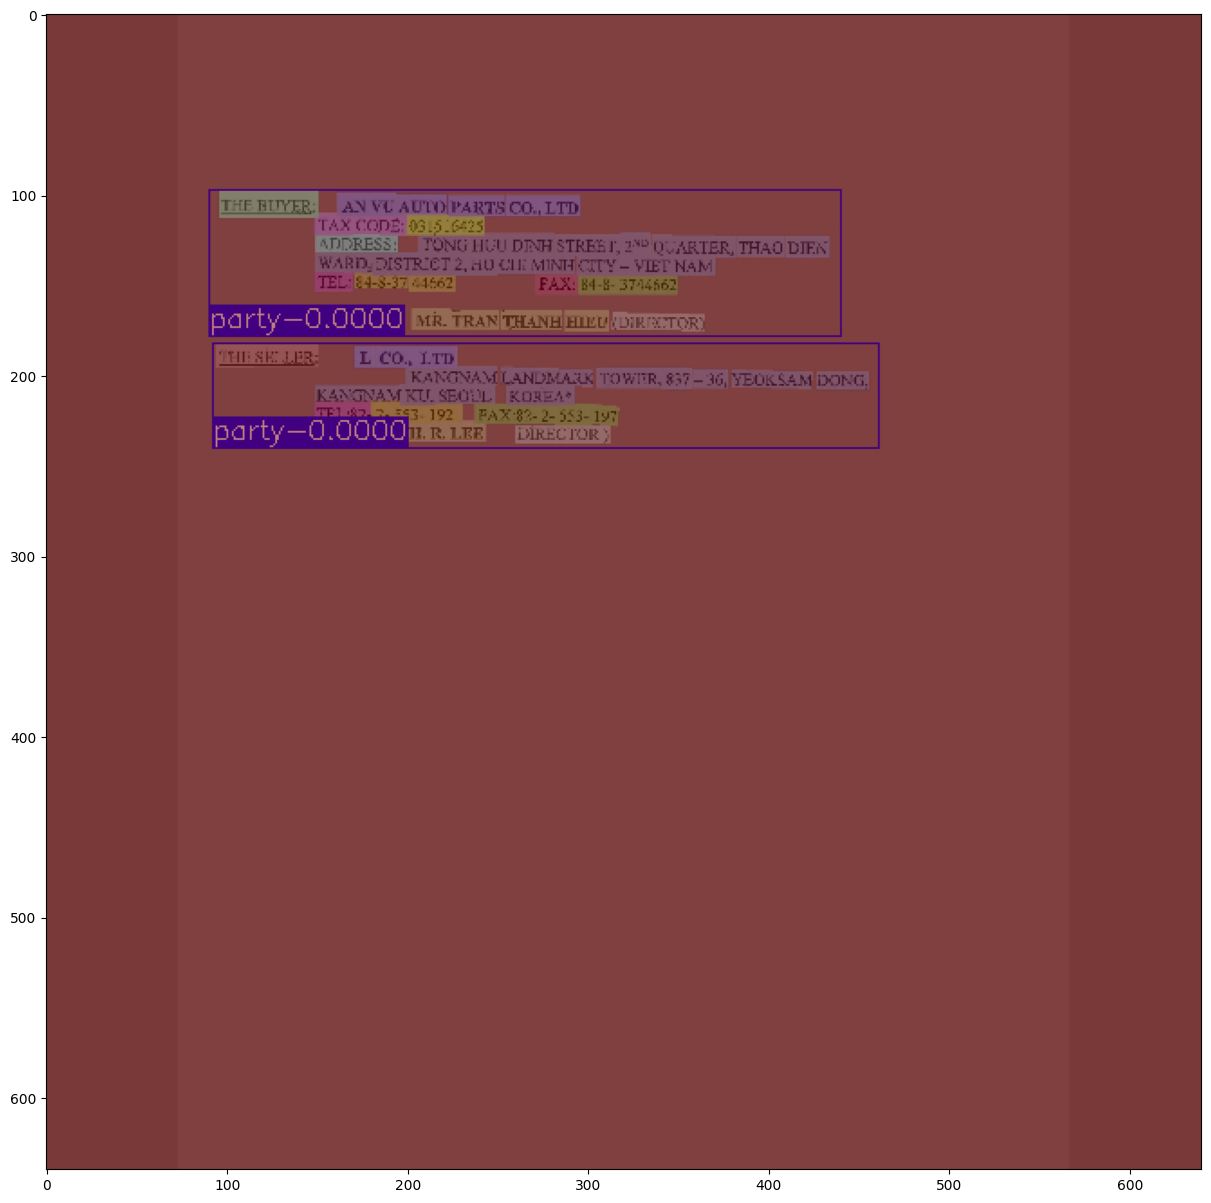

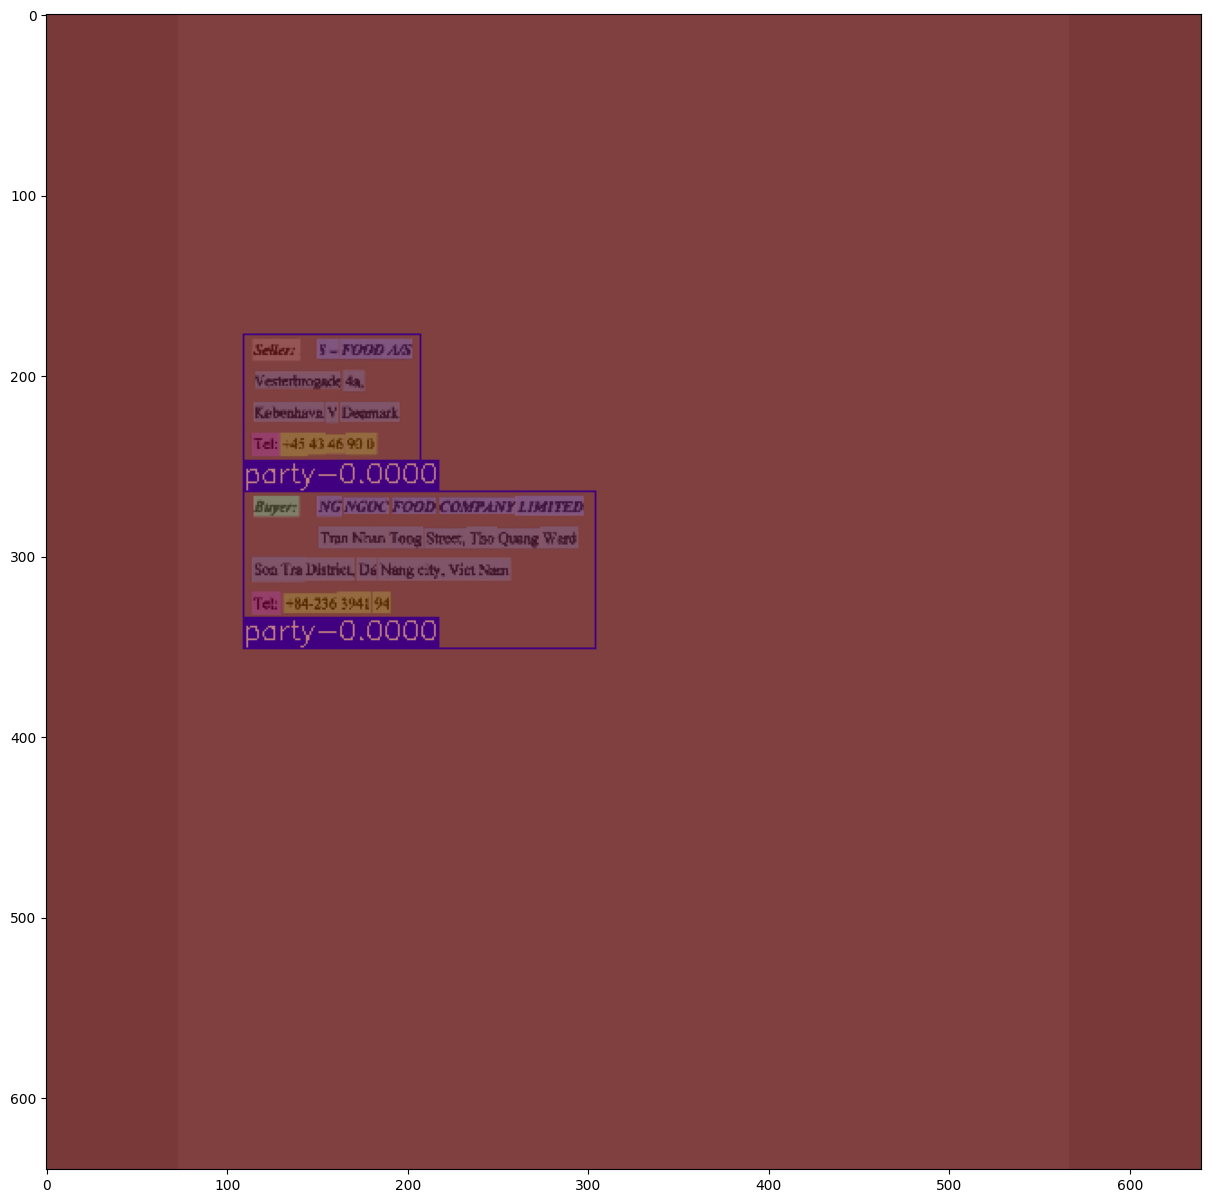

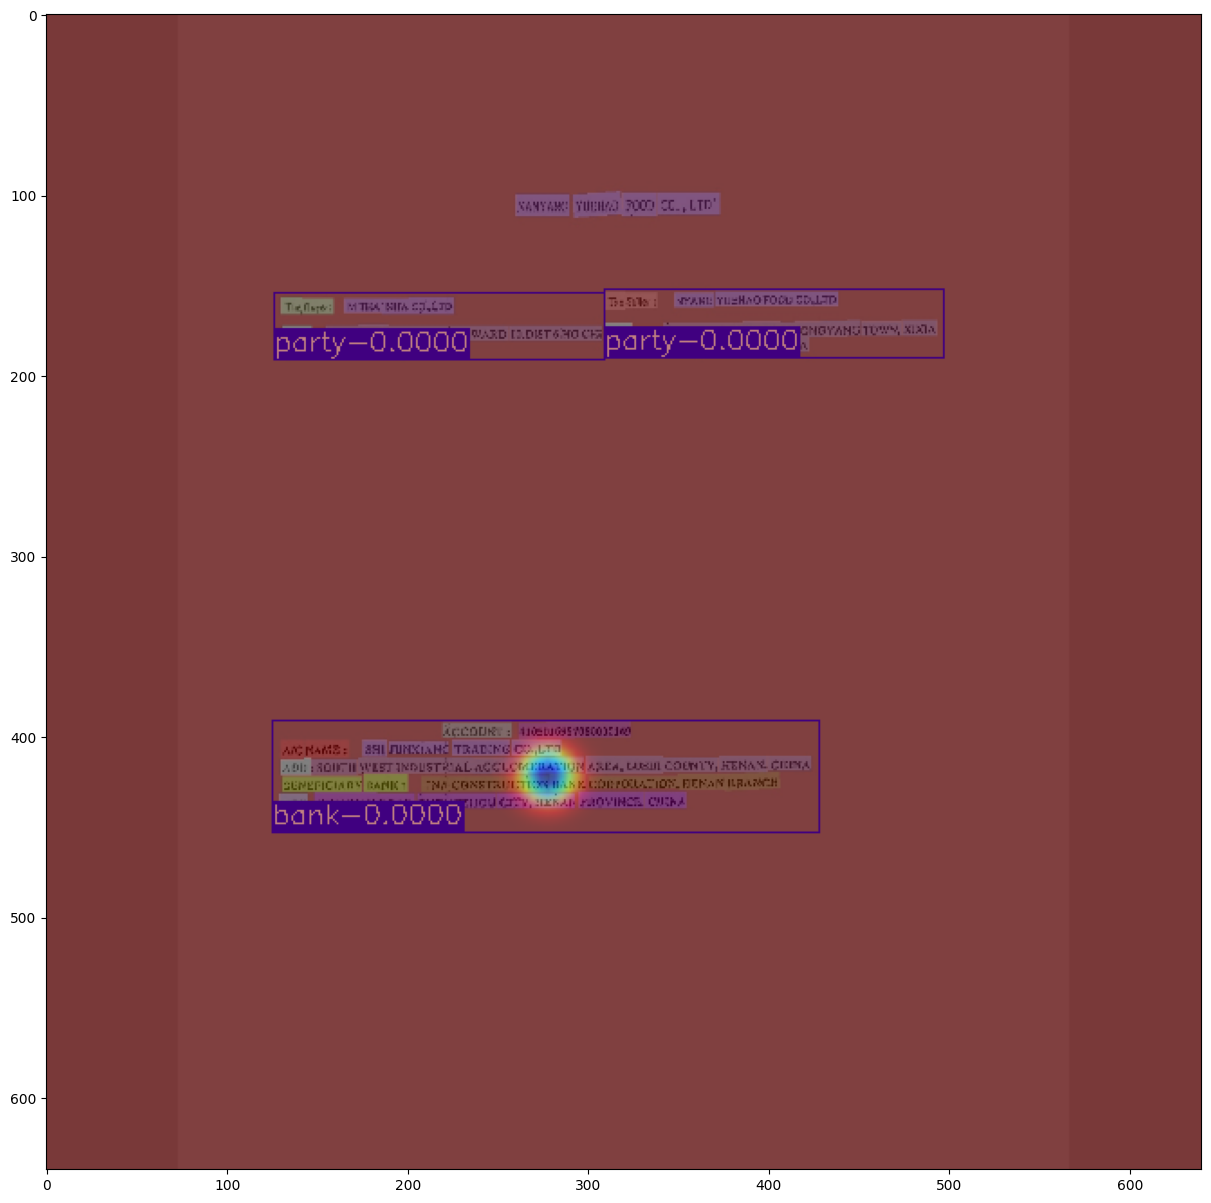

KeyboardInterrupt: Interrupted by user

In [2]:
from dataset.assigner import Assigner
from utils import parse_xml, Resizer
import yaml
import os
import cv2
import matplotlib.pyplot as plt

def draw_boxes(src_image, boxes, scores, labels):
    color = (0, 0, 255)
    for box, score, lb in zip(boxes, scores, labels):
        xmin, ymin, xmax, ymax = box.astype('int32')
        score = '{:.4f}'.format(score)
        label = '-'.join([lb, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return src_image

with open('config/contract_block.yaml') as f:
    cfg = yaml.safe_load(f)
    
path = cfg['val']
assigner = Assigner(num_classes=2, input_size=640, stride=4, max_object=100)
resizer = Resizer(size=(640, 640), mode='letterbox')
mapper = cfg['names']
for name in os.listdir(path):
    fp = os.path.join(path, name)
    xp = fp.replace('images', 'annotations').replace('.jpg', '.xml')
    img = cv2.imread(fp)
    boxes, obj_names = parse_xml(xp)
    class_ids = [mapper[obj_name] for obj_name in obj_names]
     
    resized = resizer.resize_image(img)
    new_boxes = resizer.resize_boxes(boxes, img.shape[:2])
    ## Vẽ cái box lên
    resized = draw_boxes(resized, new_boxes, [0]*len(new_boxes), obj_names)
    
    #Overlay cái thằng hm lên
    hm, whm, reg, indices = assigner(new_boxes, class_ids)
    
    # Heatmap check done [v]
    heat = cv2.applyColorMap((hm[..., 1]*255).astype('uint8'), cv2.COLORMAP_JET)
    heat = cv2.resize(heat, (640, 640))
    resized = cv2.addWeighted(resized, 0.5, heat.astype('uint8'), 0.5, 0.0)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(resized)
    plt.show()
    input()

## Check model inference

In [5]:
#Check model infer
from model_2 import Model
from dataset.assigner import Assigner
from utils import parse_xml, Resizer
from dataset.generator import Generator
import yaml
import os
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
from time import time
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

with open('config/polyps_set.yaml') as f:
    cfg = yaml.safe_load(f)

assigner = Assigner(num_classes=2, input_size=512, stride=4, max_object=100)
resizer = Resizer(size=(512, 512), mode='letterbox')

mapper = cfg['names']
model = Model(version=cfg['version'], nc=cfg['nc'], max_boxes=cfg['max_boxes'], is_training=False)
model_weights = torch.load('save_dir/polypsset_20230426/epoch=84_mAP50=0.67.ckpt',
                                 map_location='cpu')['state_dict']
for key in list(model_weights):
    model_weights[key.replace("model.", "")] = model_weights.pop(key)
model.load_state_dict(model_weights, strict=True)

model.eval()
model.fuse()
model.to(device)

Model(
  (backbone): Backbone(
    (backbone): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU()
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU()
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU()
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU()
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU()
            )
            (cv2): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU()
            )
          )
        )
      )
      (3): Conv(
        (conv

In [3]:
def draw_boxes(src_image, boxes, scores, labels, color=(0, 0, 255)):
    for box, score, lb in zip(boxes, scores, labels):
        xmin, ymin, xmax, ymax = box.astype('int32')
        score = '{:.4f}'.format(score)
        label = '-'.join([lb, score])
        ret, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(src_image, (xmin, ymin), (xmax, ymax), color, 1)
        # cv2.rectangle(src_image, (xmin, ymax - ret[1] - baseline), (xmin + ret[0], ymax), color, -1)
        # cv2.putText(src_image, label, (xmin, ymax - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return src_image

0.013206005096435547
[[164.01312 201.37714 201.7504  243.66293]
 [165.45181 201.27345 204.59781 243.61815]] [0.39469498 0.27999118] [1. 0.]


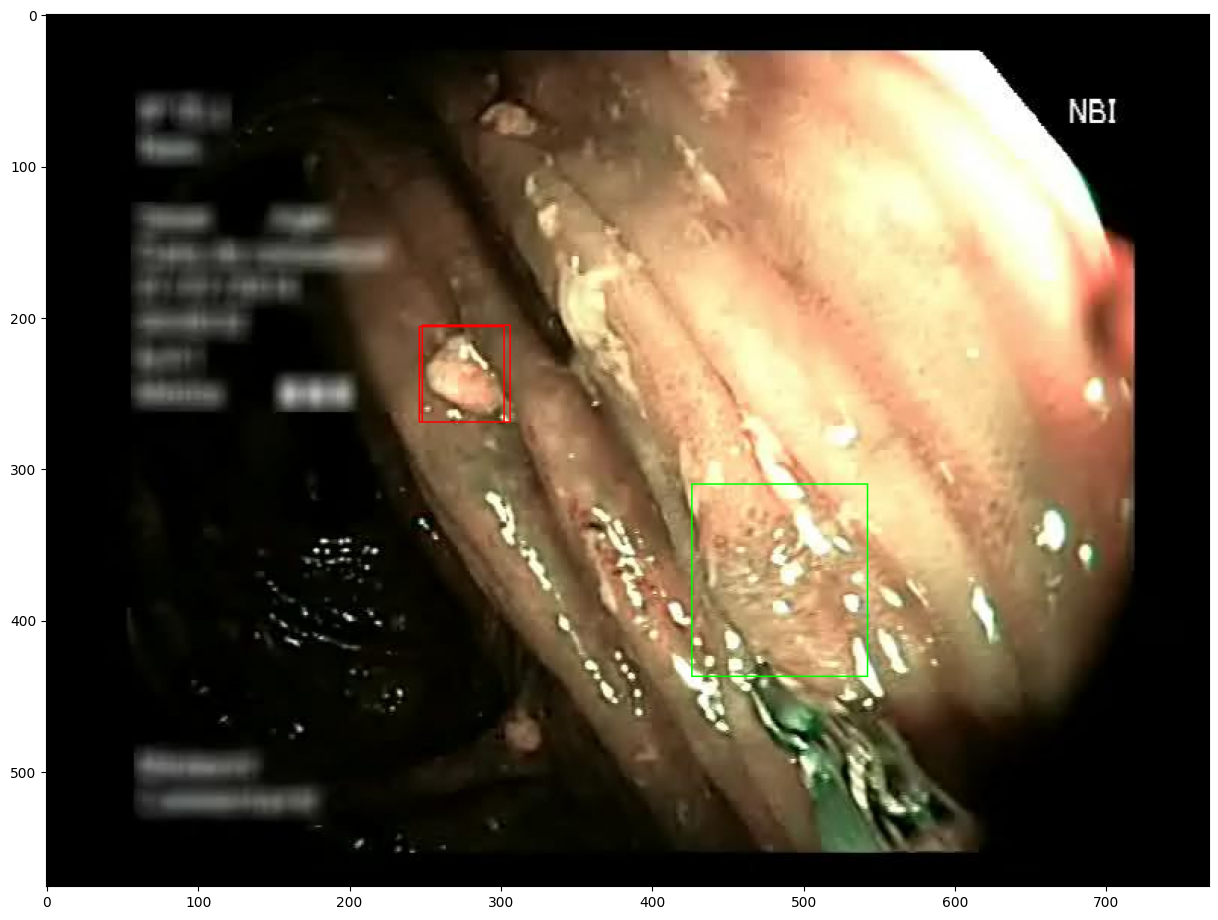

0.010265588760375977
[[242.64722 225.65277 273.30188 249.18362]
 [191.87454 209.77675 275.9766  257.86313]] [0.67152    0.19284442] [1. 1.]


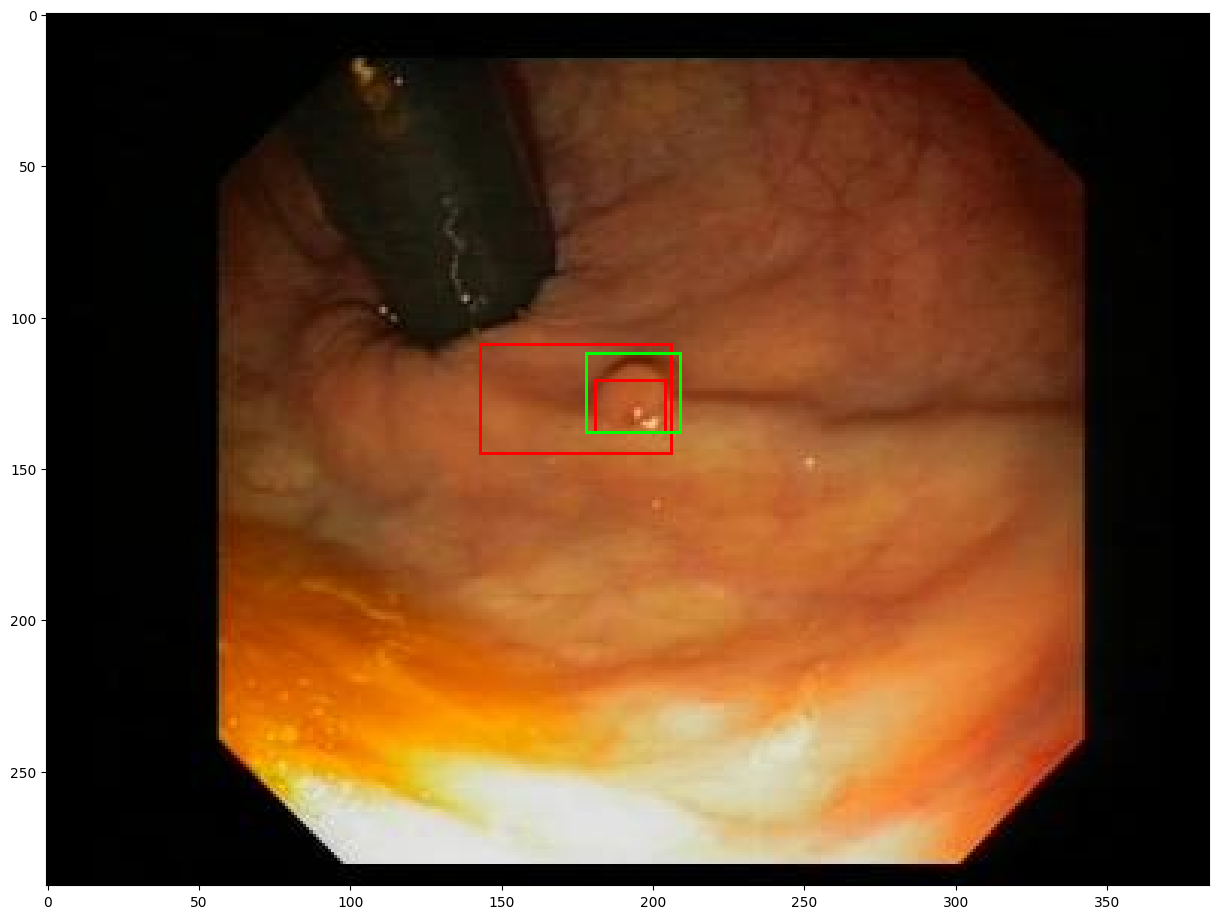

0.010618209838867188
[] [] []


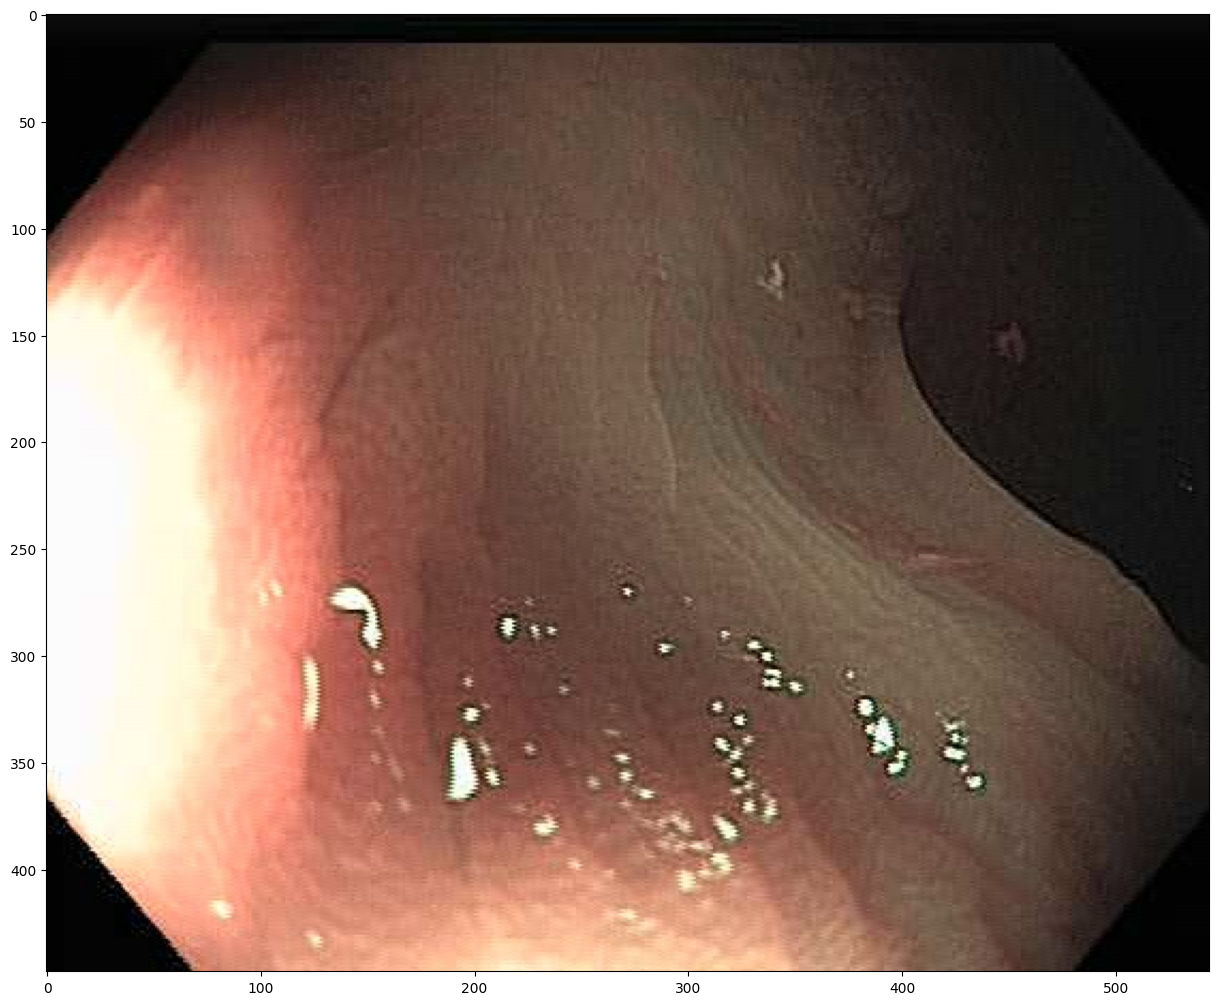

0.009714603424072266
[[316.58286   59.016144 487.26724  304.96973 ]] [0.26297036] [1.]


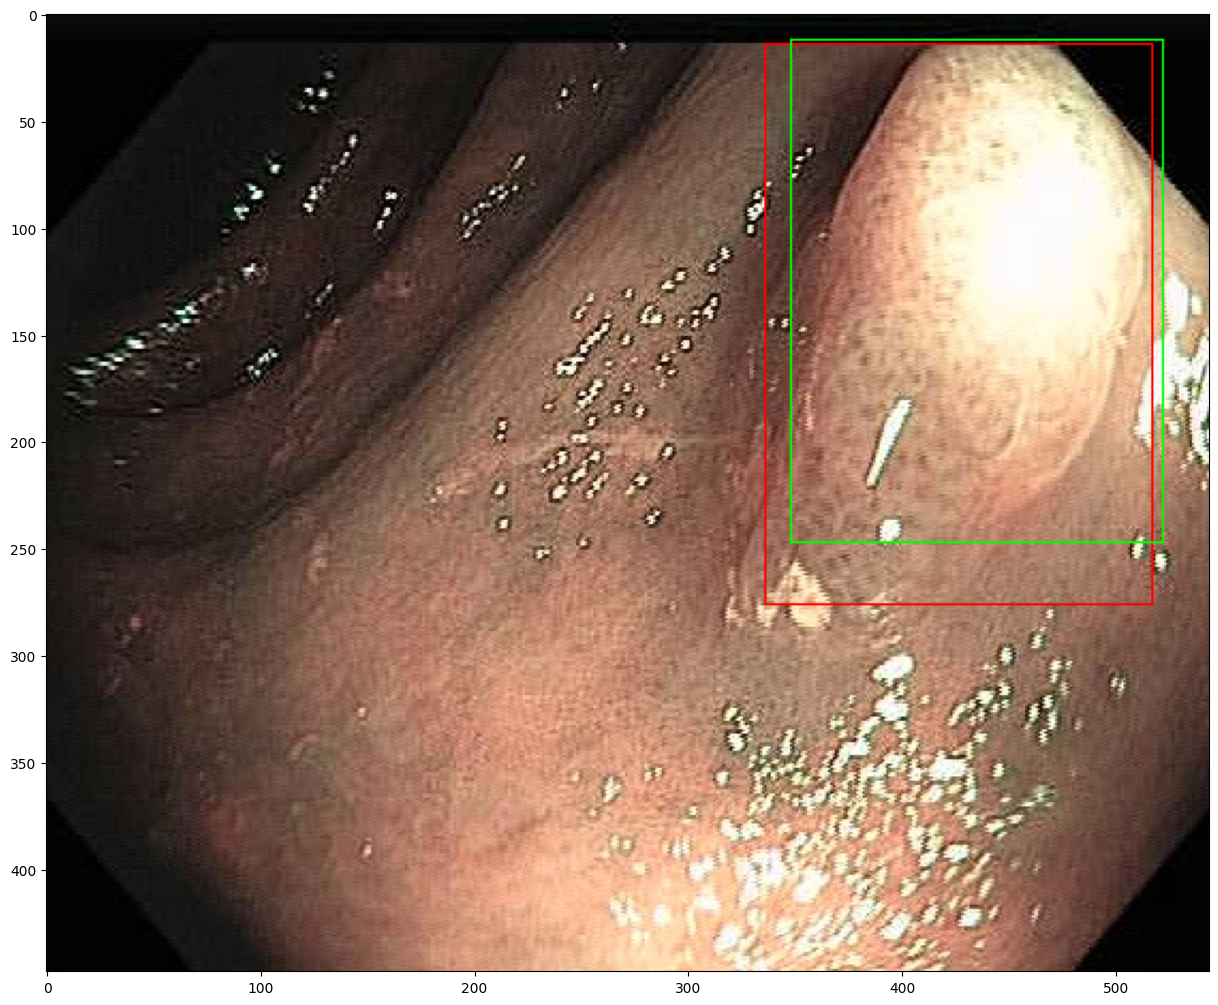

0.011616706848144531
[[ 71.470085 369.9016   212.46942  474.14777 ]
 [ 77.83669  363.17615  246.04184  480.75983 ]] [0.32251364 0.19603428] [1. 1.]


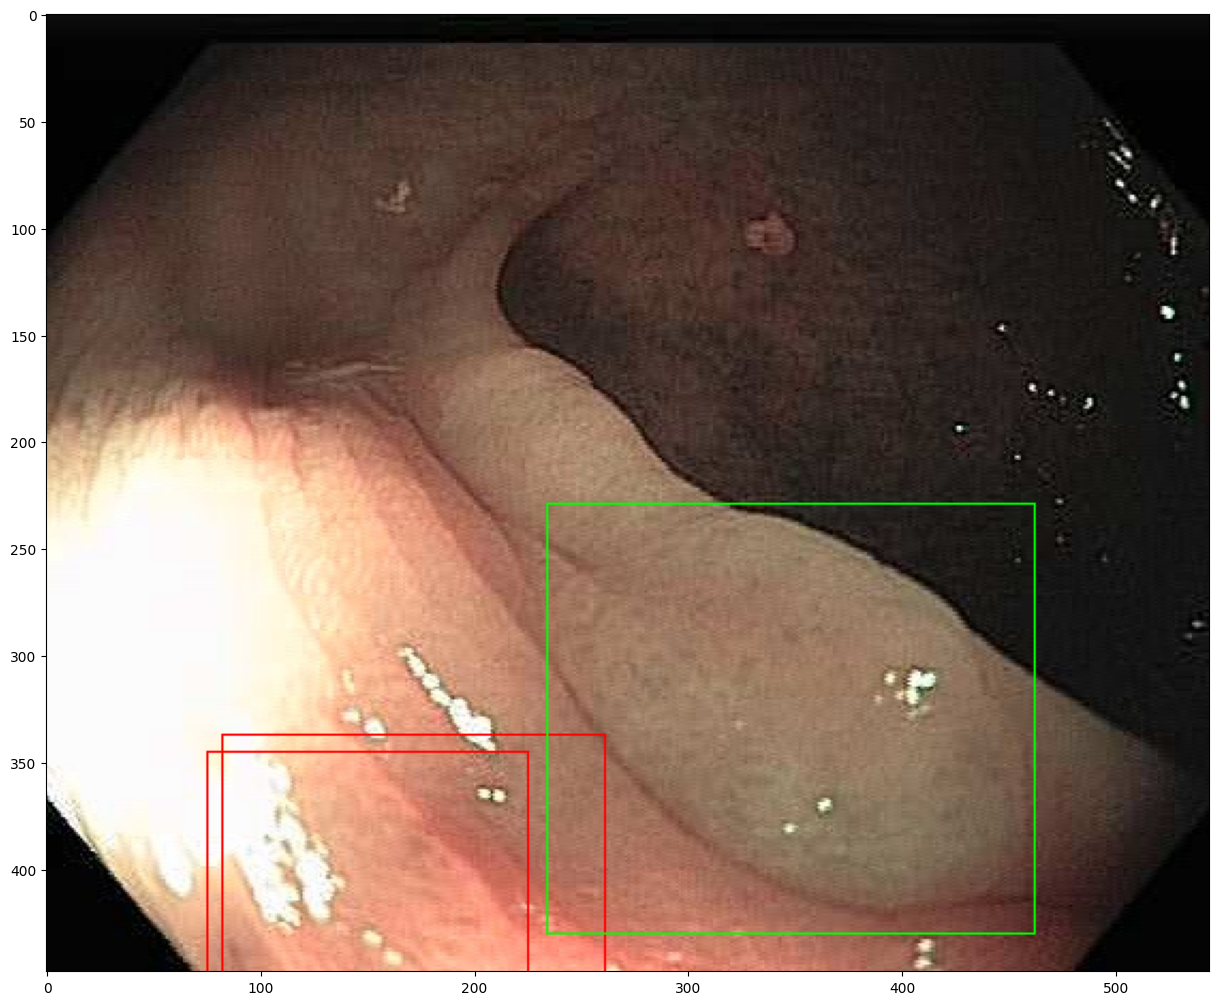

KeyboardInterrupt: Interrupted by user

In [6]:
%matplotlib inline
import logging
from time import time
logging.basicConfig(level=logging.INFO)
# print(model.device())
path = cfg['test']
for name in os.listdir(path):
    fp = os.path.join(path, name)
    xp = fp.replace('images', 'annotations').replace('.jpg', '.xml')
    img = cv2.imread(fp)
    labels_boxes, labels_obj_names = parse_xml(xp)
    labels_class_ids = [mapper[obj_name] for obj_name in labels_obj_names]
    
    # resized, new_boxes = resizer(img, boxes)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = resizer.resize_image(img)
    tensor_in = resized.astype(np.float32) / 255.0
    tensor_in = np.expand_dims(np.transpose(tensor_in, (2, 0, 1)), 0)
    tensor_in = torch.from_numpy(tensor_in).to(device)
    # print(tensor_in.shape)
    ## Vẽ cái box lên
    # resized = draw_boxes(resized, new_boxes, [0]*len(new_boxes), obj_names)
    s = time()
    with torch.no_grad():
        res = model(tensor_in)[0].cpu().numpy()
    print(time() - s)
    boxes, scores, class_ids = res[:, :4], res[:, 4], res[:, 5]
    idxs = np.where(scores > 0.1)
    boxes = boxes[idxs] * 4
    scores = scores[idxs]
    class_ids = class_ids[idxs]    
    
    # class_names = ['party' if c == 0 else 'bank' for c in class_ids]
    class_names = ['adenomatous' if c == 0 else 'hyperplastic' for c in class_ids]
    print(boxes, scores, class_ids)
    boxes = resizer.rescale_boxes(boxes, img.shape[:2])
    img = draw_boxes(img, boxes.astype('int32'), scores, class_names, color=(255, 0, 0))
    img = draw_boxes(img, np.array(labels_boxes).astype('int32'),
                     [0]*len(labels_boxes), labels_obj_names, color=(0, 255, 0)) 
    
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()
    input()

2023-04-13 08:45:37,188 - INFO - TEST
2023-04-13 08:45:37,201 - INFO - Loading labels from cache ...
2023-04-13 08:45:37,202 - INFO - Total: 4719 | Images: 4719 | Background: 0 | Empty: 153
1.350391149520874
[[     204.07      252.86      255.87      310.98]] [    0.13422] [          1]


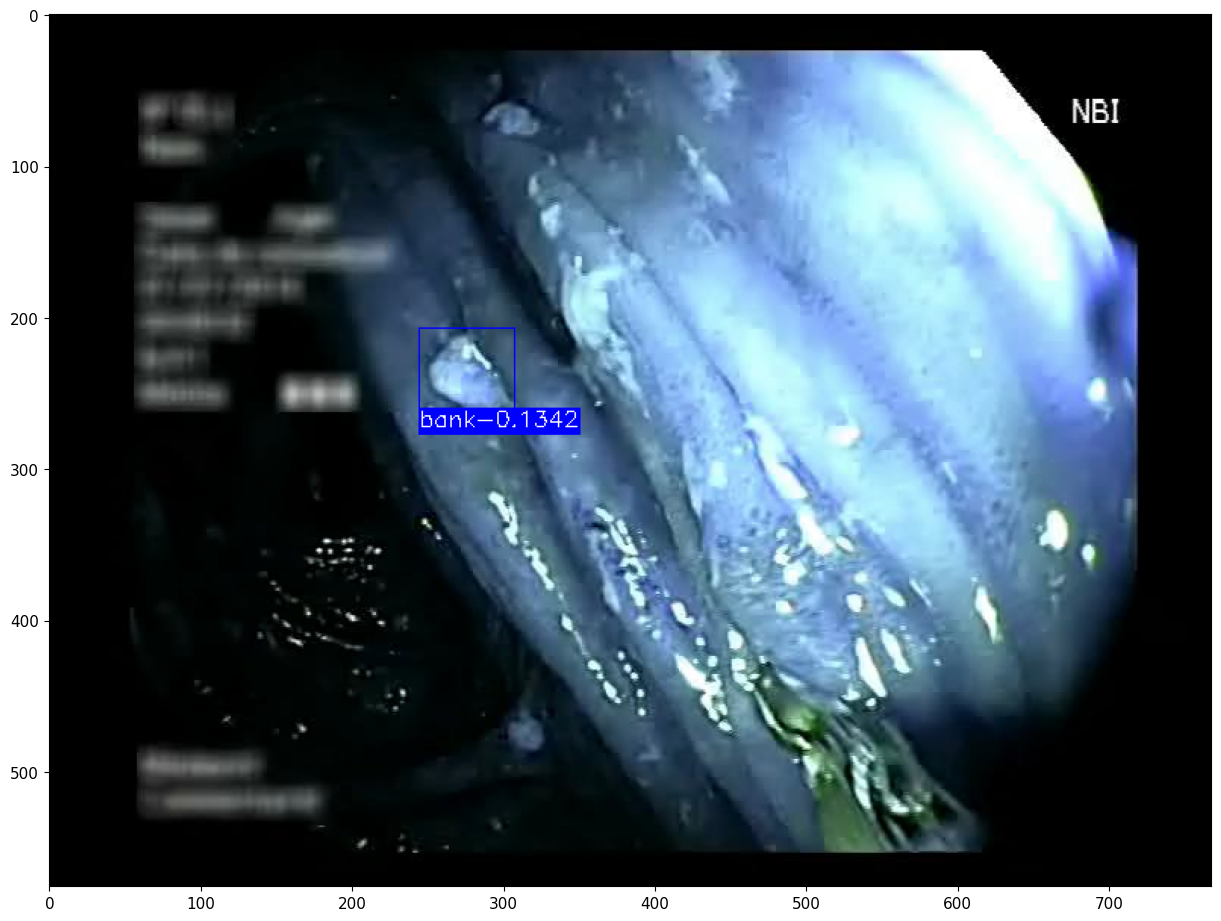

1.3155112266540527
[[     304.81      289.22      340.28      314.65]
 [     307.94      289.19      343.07      314.79]
 [     412.49      219.58      431.41       239.9]
 [     242.45      270.53      345.42      325.48]
 [     394.99      344.67      424.77      371.28]] [     0.3457     0.19884     0.18144     0.10496      0.1005] [          1           0           1           1           1]


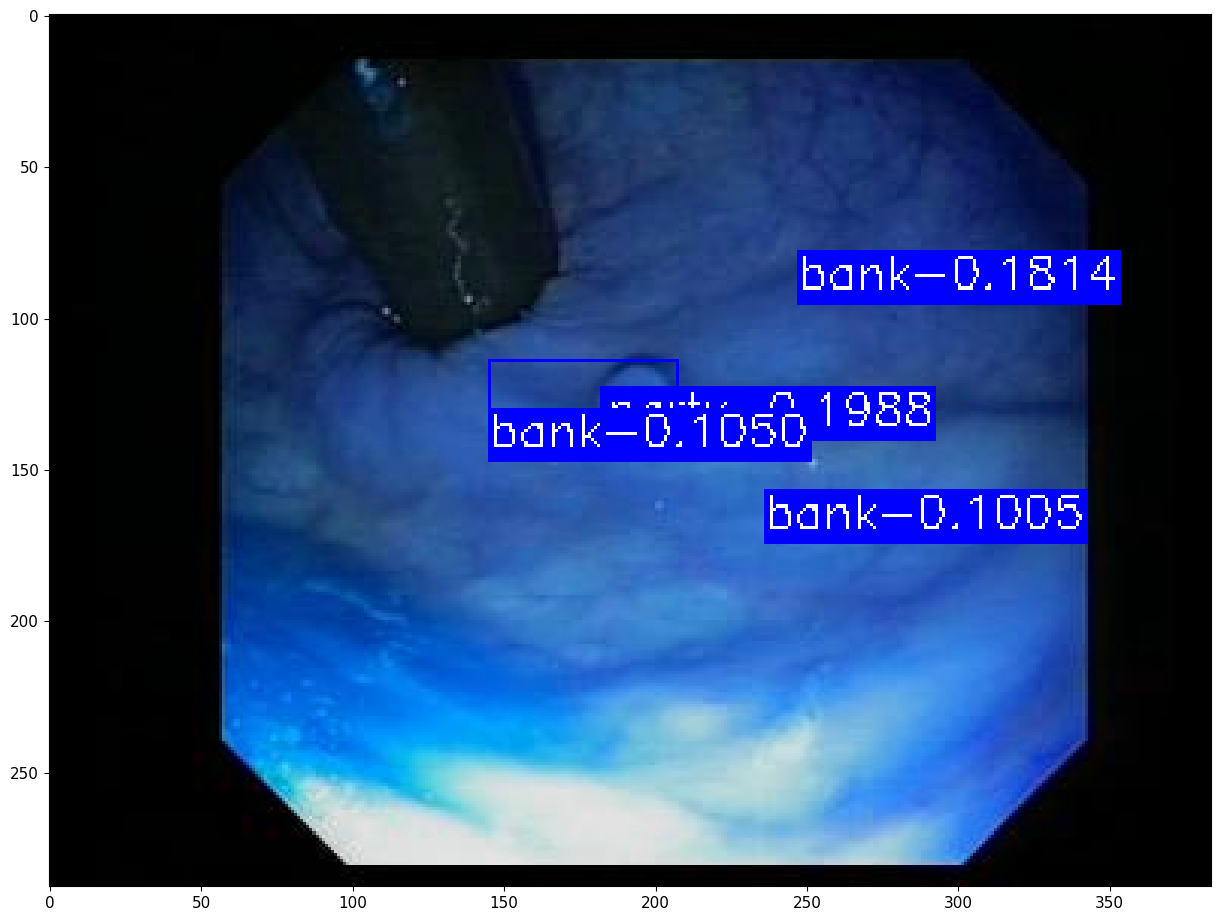

KeyboardInterrupt: Interrupted by user

In [20]:
test_dataset = Generator(cfg, mode='test')
for i, (data, target, im_path) in enumerate(test_dataset):
    # , (hm, wh, reg, indices), d['im_path']
    img = cv2.imread(im_path)
    tensor_in = np.expand_dims(np.transpose(data, (2, 0, 1)), 0)
    tensor_in = torch.from_numpy(tensor_in)#.cuda()
    # print(tensor_in.shape)
    ## Vẽ cái box lên
    # resized = draw_boxes(resized, new_boxes, [0]*len(new_boxes), obj_names)
    s = time()
    res = model(tensor_in)[0].cpu().detach().numpy()
    # out = model(tensor_in)
    # res = model.decoder(out)[0].cpu().detach().numpy()

    print(time() - s)
    boxes, scores, class_ids = res[:, :4], res[:, 4], res[:, 5]
    idxs = np.where(scores > 0.1)
    boxes = boxes[idxs] * 4
    scores = scores[idxs]
    class_ids = class_ids[idxs]    
    
    class_names = ['party' if c == 0 else 'bank' for c in class_ids]
    print(boxes, scores, class_ids)
    boxes = resizer.rescale_boxes(boxes, img.shape[:2])
    img = draw_boxes(img, boxes.astype('int32'), scores, class_names)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()
    input()